These are the parameter files, the subject file will need to be changed to match which subject you want to analyze. 

In [1]:
addpath(genpath(pwd));

% Set Parameters

par_pCASL;


------------------------------
Set PAR                                 


This is how you set which subject you are analyzing

In [2]:
PAR.subjects = {'sub5'} ;

In [3]:
PAR.subjects


ans =

  cell

    'sub5'



Reset orientation

In [5]:
% batch reset T1 orientation

global PAR
par_pCASL
fprintf('\r%-40s\n','batch reset orientation ')
%%%%% the following codes are changed from batch_smooth

% dirnames,
% get the subdirectories in the main directory
for sb = 1:PAR.nsubs % for each subject
    %go get the sessions
    str   = sprintf('sub #%3d/%3d: %-5s',sb,PAR.nsubs,PAR.subjects{sb} );
    fprintf('\r%-40s  %30s',str,' ')
    fprintf('%s%30s',repmat(sprintf('\b'),1,30),'...reseting')  %-#
    %now get all images to reset orientation
    %prepare directory
    P=[];
    for c=1:PAR.ncond
        % get files in this directory
        P=spm_select('FPList', char(PAR.condirs{sb,c}), ['^' PAR.funcimgfilters{c} '.*\.nii$']);
%         ASLtbx_resetimgorgASL(P);
        ASLtbx_resetimgorg(P);
    end

    P=spm_select('FPList', char(PAR.structdir{sb}), ['^' PAR.structprefs '.*\.nii$']);
    ASLtbx_resetimgorg(P);
    
    fprintf('%s%30s',repmat(sprintf('\b'),1,30),'...done')  %-#
end
fprintf('\n');



------------------------------
Set PAR                                 
batch reset orientation                 
sub #  1/  1: sub5                                                                       ...reseti                       ...done


In [6]:
img=load_nii(P)


img = 

  struct with fields:

           hdr: [1×1 struct]
      filetype: 2
    fileprefix: '/home/u31/mdlindley/Lab_Files/sub5/Anatomy/Anatomy'
       machine: 'ieee-le'
           img: [176×256×256 int16]
      original: [1×1 struct]



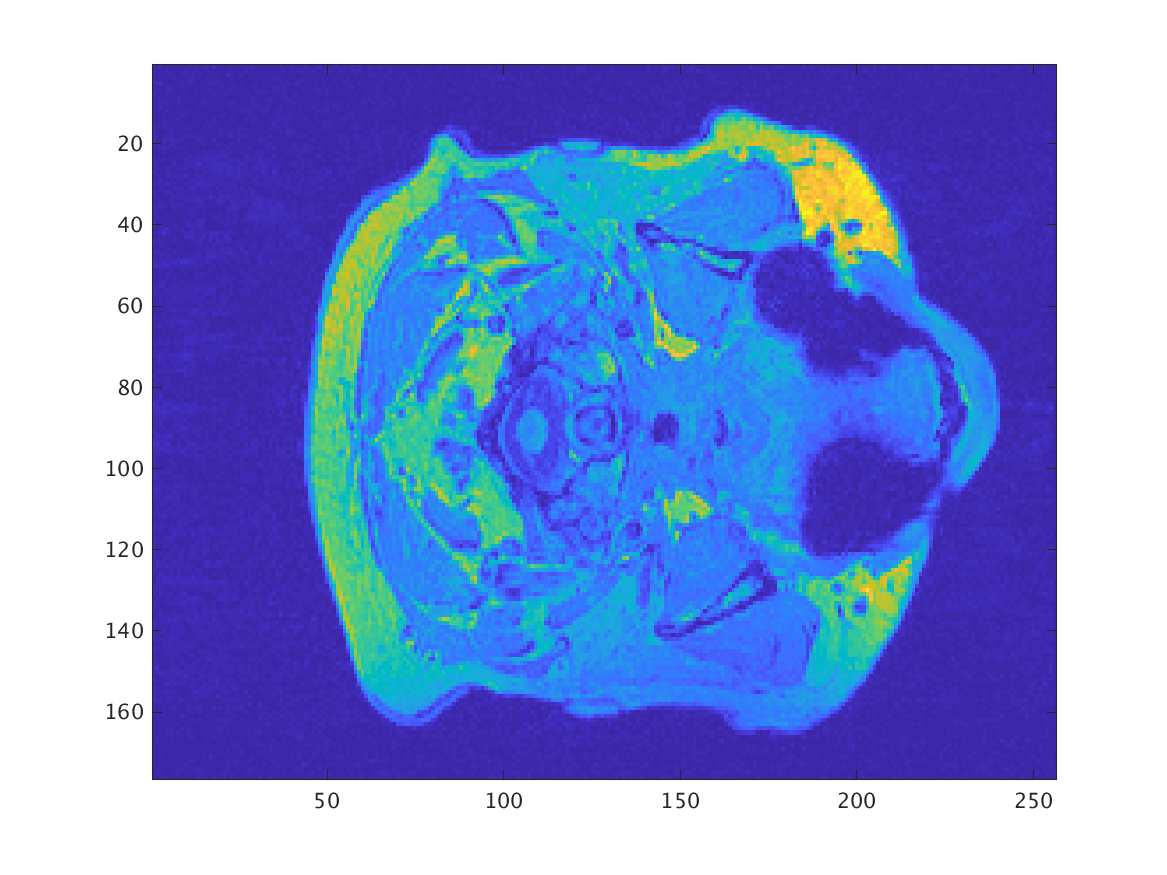

In [7]:
imatlab_export_fig('print-png')
imagesc(img.img(:,:,40))

Realign the images

In [8]:
clear
par_pCASL;
disp('We are now realigning raw EPI images for all subjects, just wait....');
% load spm defaults
global defaults;
spm_defaults;

% Get realignment defaults
defs = defaults.realign;

% Flags to pass to routine to calculate realignment parameters
% (spm_realign)

%as (possibly) seen at spm_realign_ui,
% -fwhm = 5 for fMRI
% -rtm = 0 for fMRI
% for this particular data set, we did not perform a second realignment to the mean
% the coregistration between the reference control and label volume is also omitted
reaFlags = struct(...
    'quality', defs.estimate.quality,...  % estimation quality
    'fwhm', 5,...                         % smooth before calculation
    'rtm', 1,...                          % whether to realign to mean
    'PW',''...                            %
    );

% Flags to pass to routine to create resliced images
% (spm_reslice)
resFlags = struct(...
    'interp', 1,...                       % trilinear interpolation
    'wrap', defs.write.wrap,...           % wrapping info (ignore...)
    'mask', defs.write.mask,...           % masking (see spm_reslice)
    'which',2,...                         % write reslice time series for later use
    'mean',1);                            % do write mean image


% dirnames,
% get the subdirectories in the main directory
for sb =1:PAR.nsubs % for each subject
    str   = sprintf('sub #%3d/%3d: %-5s',sb,PAR.nsubs,PAR.subjects{sb} );
    fprintf('\r%-40s  %30s',str,' ')
    P=[];
    for c=1:PAR.ncond
        % get files in this directory
        Ptmp=spm_select('ExtFPList',PAR.condirs{sb,c},['^' PAR.funcimgfilters{c} '\w*\.nii$'],1:400);
        P=strvcat(P,Ptmp);
    end
    spm_realign_asl(P, reaFlags);
    % Run reslice
    spm_reslice(P, resFlags);

end


------------------------------
Set PAR                                 
We are now realigning raw EPI images for all subjects, just wait....
Direct calls to spm_defauts are deprecated.
Please use spm('Defaults',modality) or spm_get_defaults instead.
sub #  1/  1: sub5                                                      
SPM12: spm_reslice (v5929)                         14:17:23 - 22/03/2018
Completed                               :          14:17:33 - 22/03/2018


Coregister the images

In [9]:

disp('Coregistration between structural images and the functional images for all subjects, it takes a while....');
global defaults;
spm_defaults;
flags = defaults.coreg;

% dirnames,
% get the subdirectories in the main directory
for s = 1:length(PAR.subjects) % for each subject
    %take the dir where the mean image (reslice) is stored (only first condition)
    sprintf('\nNow coregister %s''s data\n',char(PAR.subjects{s}))
    dir_fun = PAR.condirs{s,1};
    %take the structural directory
    dir_anat = PAR.structdir{s};
    % get mean in this directory
    %target - Tar(G)et image, NEVER CHANGED
    %source - Source image, transformed to match PG
    %otherimgs - (O)ther images, originally realigned to PF and transformed again to PF

    target = spm_select('FPList',PAR.structdir{s},['^' PAR.structprefs '\w*\.nii$']);
    source = spm_select('FPList', dir_fun,   ['^mean' PAR.funcimgfilters{1} '\w*\.nii$']);
    PO=[];
    for c=1:PAR.ncond
        % get files in this directory
       % Ptmp=spm_get('files', PAR.condirs{s,c}, ['r*img']);
        Ptmp=spm_select('EXTFPList', char(PAR.condirs{s,c}), ['^r' PAR.funcimgfilters{c} '.*\.nii'], 1:400);
        PO=strvcat(PO,Ptmp);
    end
    if isempty(PO) | PO=='/'
        PO=source;
    else
        PO = strvcat(source,PO);
    end
    otherimgs = PO;
    ASLtbx_spmcoreg(target, source, PO);
end


Coregistration between structural images and the functional images for all subjects, it takes a while....

ans =

    '
     Now coregister sub5's data
     '


SPM12: spm_coreg (v6435)                           14:17:33 - 22/03/2018
Completed                               :          14:17:52 - 22/03/2018


Filter the images

In [10]:
% Get subject etc parameters
disp('Smoothing the realigned functional images, it is quick....');
org_pwd=pwd;
% dirnames,
% get the subdirectories in the main directory
for sb = 1:PAR.nsubs % for each subject

    str   = sprintf('sub #%3d/%3d: %-5s',sb,PAR.nsubs,PAR.subjects{sb});
    fprintf('\r%-40s  %30s',str,' ')
    fprintf('%s%30s',repmat(sprintf('\b'),1,30),'...smoothing')  %-#

    for c=1:PAR.ncond
        meanimg=spm_select('FPList', PAR.condirs{sb,c}, ['^mean' PAR.funcimgfilters{c} '\w*\.nii$']);
        ASLtbx_createbrainmask(meanimg);
        rimgs=spm_select('EXTFPList', char(PAR.condirs{sb,c}), ['^r' PAR.funcimgfilters{c} '.*nii'], 1:1000);
        maskimg=spm_select('FPList', PAR.condirs{sb,c}, ['^brainmask\.nii']);
        ASLtbx_asltemporalfiltering(rimgs, maskimg);
    end
end

Smoothing the realigned functional images, it is quick....
sub #  1/  1: sub5                                                                      ...smoothing

Smooth the images

In [11]:
% Get subject etc parameters
disp('Smoothing the realigned functional images, it is quick....');
org_pwd=pwd;
% dirnames,
% get the subdirectories in the main directory
for sb = 1:PAR.nsubs % for each subject

    str   = sprintf('sub #%3d/%3d: %-5s',sb,PAR.nsubs,PAR.subjects{sb});
    fprintf('\r%-40s  %30s',str,' ')
    fprintf('%s%30s',repmat(sprintf('\b'),1,30),'...smoothing')  %-#

    for c=1:PAR.ncond
        %P=[];
        %dir_func = fullfile(PAR.root, PAR.subjects{s},PAR.sesses{ses},PAR.condirs{c});
        
              
        fltimgs=spm_select('FPList', PAR.condirs{sb,c}, '^ASLflt.*nii'); 
        

        if isempty(fltimgs), fprintf('You didn''t selecte any images!\n'); return;end;
        if size(fltimgs,1)==1
            [pth,nam,ext,num] = spm_fileparts(fltimgs);
            fltimgs=fullfile(pth, [nam ext]);
        end
        [pth,nam,ext,num] = spm_fileparts(fltimgs(1,:));
         ASLtbx_smoothing(fltimgs, PAR.FWHM);
        
       
    end

end
cd(org_pwd);

Smoothing the realigned functional images, it is quick....
sub #  1/  1: sub5                                                                      ...smoothing

Create masks for perfusion signals

In [12]:
global PAR
par_pCASL;
for sb = 1:PAR.nsubs % for each subject
    clear P;
    for c=1:PAR.ncond
        % creating a mask image for removing background
        dir_fun = PAR.condirs{sb,1};
        PF=spm_select('ExtFPList',PAR.condirs{sb,c},['^mean' PAR.funcimgfilters{c} '\w*\.nii$'],1:200);
        if size(PF,1)<1
            fprintf('No mean images for subject %s!\n',PAR.subjects{sb});
            continue;
        end
        PF=PF(1,:);
        vm=spm_vol(PF);
        dat=spm_read_vols(vm);
        mask=dat>0.2*max(dat(:));
        vo=vm;
        [path,name,ext]=fileparts(PF);
        vo.fname=fullfile(path,'brainmask_nat.nii');
        vo=spm_write_vol(vo,mask);
    end
end

------------------------------
Set PAR                                 


Perfusion calculation

In [13]:
for sb = 1:PAR.nsubs % for each subject

    sprintf('Calculate perfusion and CBF signals for subject #%g ... %g subjects left...',sb,length(PAR.subjects)-sb)
    for c=1:PAR.ncond

        P=[];
        %ptmp=spm_get('files', PAR.condirs{s,1}, [PAR.subjects{s} '*' PAR.confilters{1} '*img']);
        %P=ptmp(1,:);
        % creating a mask image for removing background
        maskimg = spm_select('FPList', PAR.condirs{sb,c},    ['^brainmask_nat\w*\.nii$']);
        Filename =  spm_select('ExtFPList', PAR.condirs{sb,c}, ['^sASLflt.*\.nii'], 1:1000 );
        %        spm_perf_subtract(Filename,FirstimageType, SubtractionType,...
        %           SubtractionOrder,Flag,Timeshift,AslType,MagType,Labeltime,Delaytime,Slicetime,M0img,M0seg,maskimg)
        
                %asl_perf_subtract(Filename,FirstimageType, SubtractionType,...
        %   SubtractionOrder,Flag,
        %Timeshift,AslType,labeff,MagType,
        %   Labeltime,Delaytime,Slicetime,TE,M0img,M0seg,maskimg)
        
        % These are the values that impact the actual calculation of the
        % perfusion 
        FirstImage=0; % What is the first image? Control or label
        SubtractionType = 0; 
        SubtractionOrder=0;
        % Flag is more complex, these settings ask what outputs you would
        % like to save and create
        % Flag = [1 1 1 0 0 1 0]; % For PASL
        Flag = [1 1 1 0 0 1 0 1 1]; % For pCASL
        Timeshift = 0.5;
        AslType = 1; % Is the ASL PASL, CASL, or pCASL? 0=PASL, 1=CASL/pCASL 
        labeff=0.85; % What is the label efficiency? 
        MagType = 1; % What field strength? 0 = 1.5T, 1=3T
        Labeltime= 1.48; % What is the labeling time?
        DelayTime = 1.5; % What is the post labeling delay? 
        SliceTime = 33.5; % To correct for slice timing delays, what is the slice time (only for 2D acquisitions
        TE=11; % What is the TE for the acquisition?
   
        
        asl_perf_subtract(Filename, FirstImage, SubtractionType, ...
            SubtractionOrder, Flag, Timeshift,     AslType,     labeff, MagType,...
            Labeltime, DelayTime, SliceTime, TE, [],[],maskimg);
        % labeling time=1.48s, post labeling delay=1.5 s, slice time=33.5
        % msec, TE=11 msec, no explicit M0 image, no mask for extracting M0
        % value (like M0 white matter etc) provided.
    end
end


ans =

    'Calculate perfusion and CBF signals for subject #1 ... 0 subjects left...'

This try-catch syntax will continue to work in R2007b, but may be illegal or may mean something different in future releases of MATLAB.
See MATLAB R2007a Release Notes, "Warning Generated by try-catch" for details.
This try-catch syntax will continue to work in R2007b, but may be illegal or may mean something different in future releases of MATLAB.
See MATLAB R2007a Release Notes, "Warning Generated by try-catch" for details.
This try-catch syntax will continue to work in R2007b, but may be illegal or may mean something different in future releases of MATLAB.
See MATLAB R2007a Release Notes, "Warning Generated by try-catch" for details.
This try-catch syntax will continue to work in R2007b, but may be illegal or may mean something different in future releases of MATLAB.
See MATLAB R2007a Release Notes, "Warning Generated by try-catch" for details.
This try-catch syntax will continue to work in R200

In [14]:
CBF=load_nii('../sub5/ASL_S1/meanCBF_0_sASLflt_rASLREST.nii')


CBF = 

  struct with fields:

           hdr: [1×1 struct]
      filetype: 2
    fileprefix: '../sub5/ASL_S1/meanCBF_0_sASLflt_rASLREST'
       machine: 'ieee-le'
           img: [64×64×20 single]
      original: [1×1 struct]



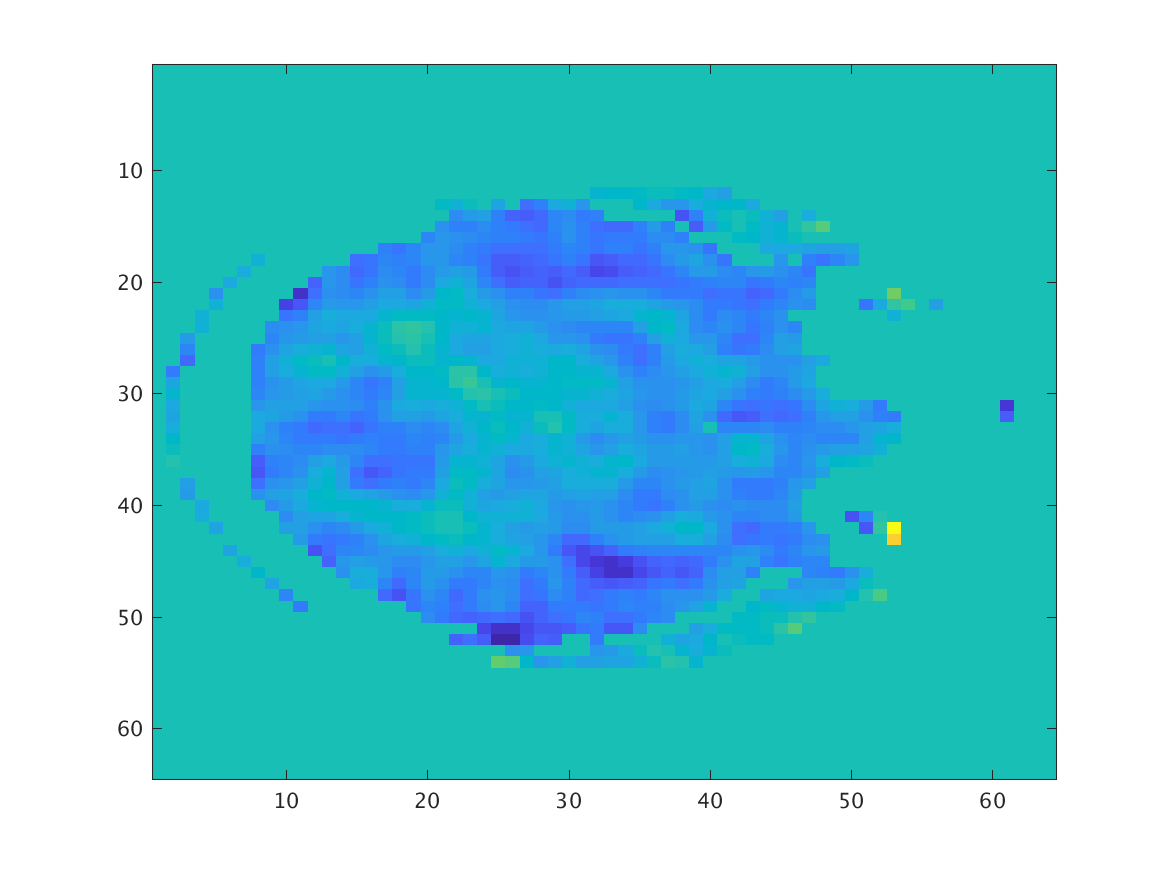

In [17]:
imagesc(CBF.img(:,:,9))